# BERT Topic Modeling of Survey Measurements of Masculinity

Purpose: Employ BERT, a topic modeling algorithm, to automatically cluster text data into particular topics. In this particular example, I am analyzing the common topics/themes of ~500 survey questions from surveys that measure masculinity. 

Topic Modeling Information: https://maartengr.github.io/BERTopic/index.html

Inspiration: https://github.com/pinecone-io/examples/tree/master/learn/experimental/algos-and-libraries/bertopic

## Imports and Setup

In [2]:
from bertopic import BERTopic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%run Functions/Functions.ipynb

In [3]:
df = pd.read_csv('../Data/Questions_Final.csv')

# Comment the following line if evaluating more than the CMNI
df = df[df["Scale"] == "Conformity to Masculine Norms Inventory"]

print(df.shape)
# Put questions in a list
docs = df['Question Text'].to_list()

(94, 7)


## Naive BERTopic (default hyperparameters)

In [118]:
# Naive vectorizer to remove stop words
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(vectorizer_model=vectorizer_model, nr_topics='auto')
# fit model
topics, probs = topic_model.fit_transform(docs)

In [119]:
topic_info_df = topic_model.get_topic_info()
topic_info_df

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14,-1_gay_thought_people_help,"[gay, thought, people, help, heterosexual, thi...",[If someone thought I was gay‚ I would not arg...
1,0,33,0_feelings_women_men_sex,"[feelings, women, men, sex, emotional, person,...",[Men and women should respect each other as eq...
2,1,26,1_work_important_winning_win,"[work, important, winning, win, things, help, ...","[It is important for me to win, Work is not th..."
3,2,21,2_risks_way_violence_prefer,"[risks, way, violence, prefer, risky, necessar...","[I enjoy taking risks, In general‚ I do not li..."


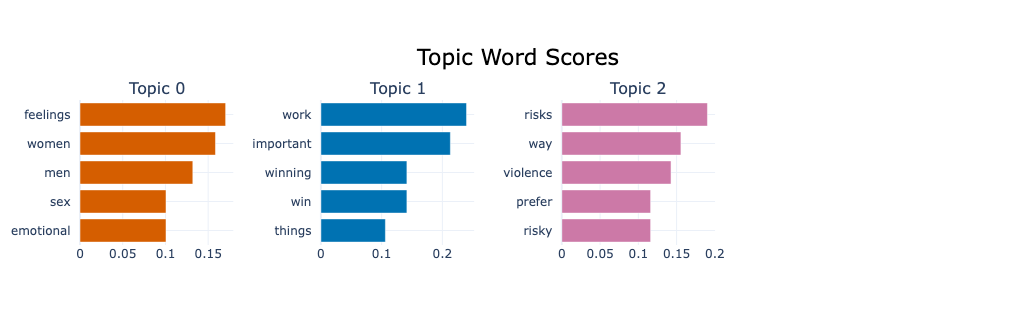

In [166]:
bar_chart = topic_model.visualize_barchart()

# Update filepath as needed
bar_chart.write_image("../Visualizations/BERTopic_Bar_Chart.png", width=800, height=600)
bar_chart

In [121]:
# Visualize Topics
# intertopic_map = model.visualize_topics().show()
# heat_map = topic_model.visualize_heatmap()

# # Update filepath as needed to save
# heat_map.write_image("../Visualizations/BERTopic_Heat_Map.png", width=800, height=600)
# heat_map

## Investigate Factor Loadings of Original CMNI vs. BERTopic

In [122]:
### Get cluster assignments of BERTopic and then merge into dataset
full_BERTopic_info = topic_model.get_document_info(docs)

# Join the "Document" column of full_BERTopic_info with the "Question Text" column of df
merged_df = pd.merge(df, full_BERTopic_info, left_on="Question Text", right_on="Document", how="inner")

# Drop the duplicate "Document" column if needed
merged_df.drop("Document", axis=1, inplace=True)

merged_df_subset = merged_df[["Factor", "Question Text", "Topic", "Name"]]
# Rename columns for readability
merged_df_subset = merged_df_subset.rename(columns={
    "Question Text": "Document",
    "Factor": "Original Factor",
    "Topic": "BERTopic Topic",
    "Name": "BERTopic Name"
})

merged_df_subset = merged_df_subset[['Document', 'Original Factor', 'BERTopic Topic', 'BERTopic Name']]
merged_df_subset.head()

,Document,Original Factor,BERTopic Topic,BERTopic Name
0,It is best to keep your emotions hidden,Emotional Control,0,0_feelings_women_men_sex
1,In general‚ I will do anything to win,Winning,1,1_work_important_winning_win
2,If I could‚ I would frequently change sexual p...,Playboy,0,0_feelings_women_men_sex
3,If there is going to be violence‚ I find a way...,Violence,2,2_risks_way_violence_prefer
4,It is important to me that people think I am h...,Disdain for Homosexuals,-1,-1_gay_thought_people_help


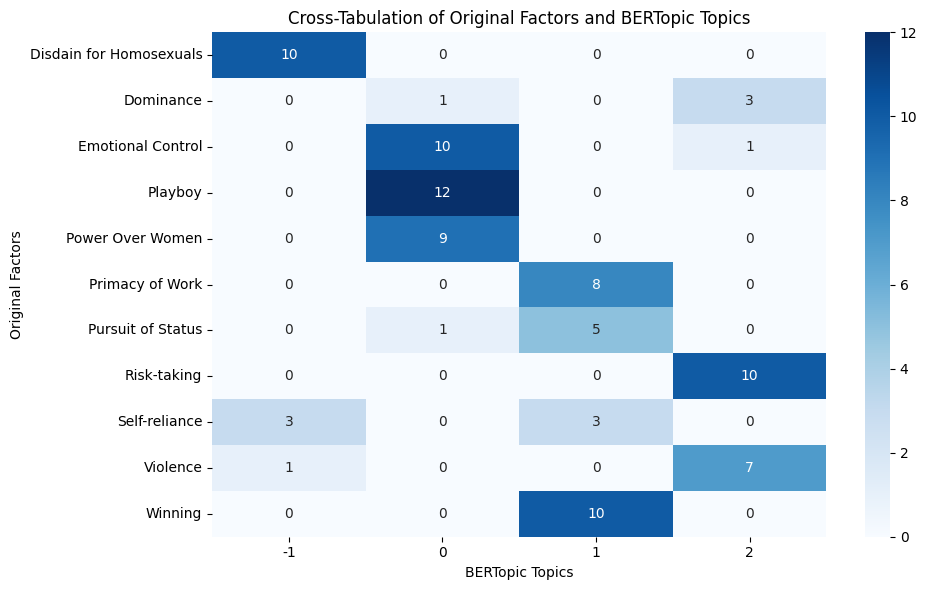

In [123]:
# Create a cross-tabulation table to count the frequency of occurrences of each combination of "Original Factor" and "BERTopic Topic".
cross_tab = pd.crosstab(merged_df_subset["Original Factor"], merged_df_subset["BERTopic Topic"])

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, cmap="Blues", annot=True, fmt="d")
plt.title("Cross-Tabulation of Original Factors and BERTopic Topics")
plt.xlabel("BERTopic Topics")
plt.ylabel("Original Factors")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("../Visualizations/BERTopic_CrossTab.png")
plt.show()

In [124]:
# Perform chi-squared test of independence to determine whether there is a stat. sig. assoc. 
# to see whether obs. freqs. in the contingency table differ significantly.
from scipy.stats import chi2_contingency

# Convert text values to categorical variables
merged_df_subset["Original Factor"] = pd.Categorical(merged_df_subset["Original Factor"])
merged_df_subset["BERTopic Topic"] = pd.Categorical(merged_df_subset["BERTopic Topic"])

# Create a contingency table
contingency_table = pd.crosstab(merged_df_subset["Original Factor"], merged_df_subset["BERTopic Topic"])

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2)
print("P-value:", p_value)
print("Degrees of freedom:", dof)
print("Expected frequencies table:")
print(expected)

Chi-squared statistic: 239.17496770905862
P-value: 1.8388532202948052e-34
Degrees of freedom: 30
Expected frequencies table:
[[1.4893617  3.5106383  2.76595745 2.23404255]
 [0.59574468 1.40425532 1.10638298 0.89361702]
 [1.63829787 3.86170213 3.04255319 2.45744681]
 [1.78723404 4.21276596 3.31914894 2.68085106]
 [1.34042553 3.15957447 2.4893617  2.0106383 ]
 [1.19148936 2.80851064 2.21276596 1.78723404]
 [0.89361702 2.10638298 1.65957447 1.34042553]
 [1.4893617  3.5106383  2.76595745 2.23404255]
 [0.89361702 2.10638298 1.65957447 1.34042553]
 [1.19148936 2.80851064 2.21276596 1.78723404]
 [1.4893617  3.5106383  2.76595745 2.23404255]]


## How does BERTopic work?

**Data -> Sentence Embeddings** (transforming text into machine readable version - usually 768/384 dimensions)


Sentence Embeddings via Transformers Architecture
    Transformers use an encode/decode network. English into a context vector and then decoded. However the context vector is so complex this creates a bottleneck into the decoder. So the attention mechanism tells which decoder parts to focus on. In 2017, attention paper released that found they can remove the recurrent parts of the network and just keep the attention mechanism so high-performing. (called a transformer).

New attention (transformer): 
(1) have positional encoding (sense of order of the tokens)
(2) self-attention (how a word is applied to all other words in the sentence). Rather than embed the meaning of the individual word, it embeds the context of the words around it.
(3) multi-head attention (parallelization)

We can take a pre-trained core (e.g. BERT) and can fine-tune it.

So now we have a vector with 768/384 dimensions.

    
**Embeddings -> UMAP** (dimensionality reduction)

UMAP helps us compress embeddings into a smaller vector small (2 or 3 dimensions).
Understands density of particular areas in the data through k_nearest_neighbors. Understands distance between different vector rows


**UMAP -> clustering with HDBSCAN**
Here we can define the number of points needed to define a cluster. (by default something like 5)

(Number of topics can be determined by how we set parameters like min_cluster_size and min_samples (how dense the core of a cluster needs to be to group))

**clustering with HDBSCAN -> C-TF-IDF**
Looks at freq. of words with a particular cluster, and see how common these words are.


## Customizing BERTopic

Inspiration: https://www.pinecone.io/learn/bertopic/

For information on the meaning of parameters, look up the Functions.ipynb file

In [125]:
docs = df['Question Text'].to_list()

In [126]:
# Defining embedding_model and vectorizer_model outside the run_custom_BERTopic function as they are required for evaluation metrics as well
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

# Most popular model - Hugging Face: https://huggingface.co/sentence-transformers?sort_models=downloads#models
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# remove stopwords/stop phrases containing 1 and 2 words
# NGRAM_RANGE is an important choice
stop_words = list(stopwords.words('english'))
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=stop_words)


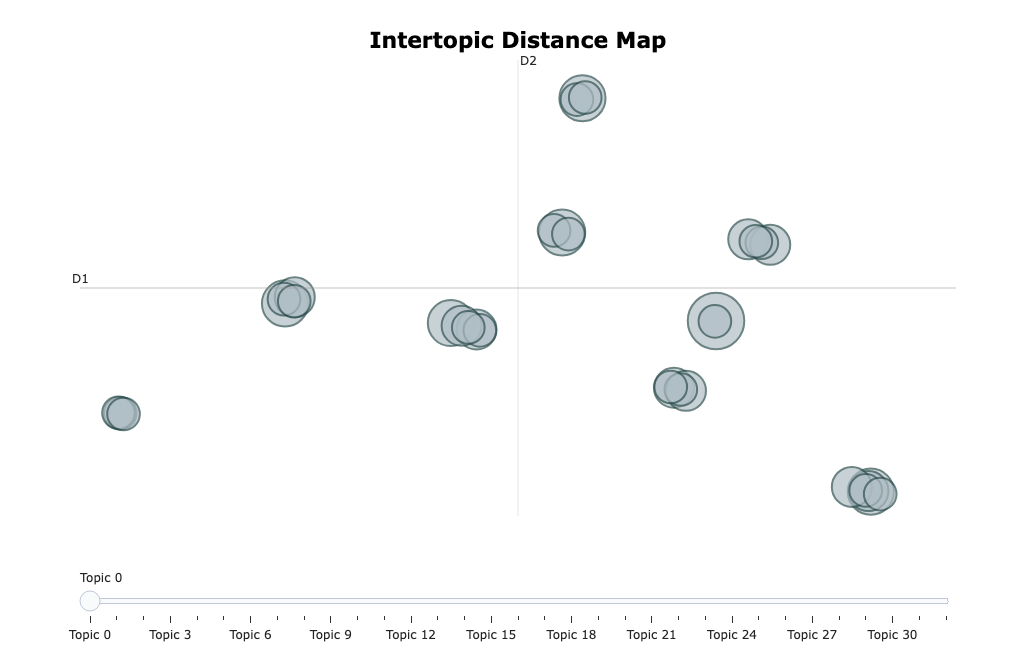

In [127]:
# Run custom model
model = run_custom_BERTopic(docs, embedding_model, vectorizer_model, min_cluster_size=2, min_samples=1)
#model = run_custom_BERTopic(docs, embedding_model, vectorizer_model, min_cluster_size=10, min_samples=10)
topics, probs = model.fit_transform(docs)

topic_info_df = model.get_topic_info()

num_topics = len(topic_info_df) - 1 # DOES NOT INCLUDE OUTLIERS TOPIC. ONLY COHERENT TOPICS
#topic_info_df

# Visualize Topics
model.visualize_topics()

## Evaluation Metrics

In [128]:
### GET FULL BERTopic INFO

full_BERTopic_info = model.get_document_info(docs)

# Join the "Document" column of full_BERTopic_info with the "Question Text" column of df
merged_df = pd.merge(df, full_BERTopic_info, left_on="Question Text", right_on="Document", how="inner")

# Drop the duplicate "Document" column if needed
merged_df.drop("Document", axis=1, inplace=True)

merged_df_subset = merged_df[["Factor", "Question Text", "Topic", "Name"]]
# Rename columns for readability
merged_df_subset = merged_df_subset.rename(columns={
    "Question Text": "Document",
    "Factor": "Original Factor",
    "Topic": "BERTopic Topic",
    "Name": "BERTopic Name"
})

In [167]:
### Gather evaluation metrics

# Create an empty DataFrame with columns for the metrics
metrics_df = pd.DataFrame(columns=['Coherence (NPMI)', 'Silhouette Score', 'ARI', 'Purity', 'NMI'])


coh = coherence_score(docs, model, vectorizer_model)

# play with seeing if you actually need topics param here
sil = silhouette_metric(docs, embedding_model, model, topics)

true_values = merged_df_subset['Original Factor']
predicted_values = merged_df_subset['BERTopic Topic'] # NOTE THAT TOPIC -1 is included in the predicted_labels. Should we remove?!?!?!
ari, purity, nmi = evaluation_metrics(true_values, predicted_values)

metrics_df.loc["model 1"] = [coh, sil, ari, purity, nmi]

metrics_df

,Coherence (NPMI),Silhouette Score,ARI,Purity,NMI
model 1,0.260278,0.636757,0.296786,0.882979,0.739788


## Comparing Multiple Models

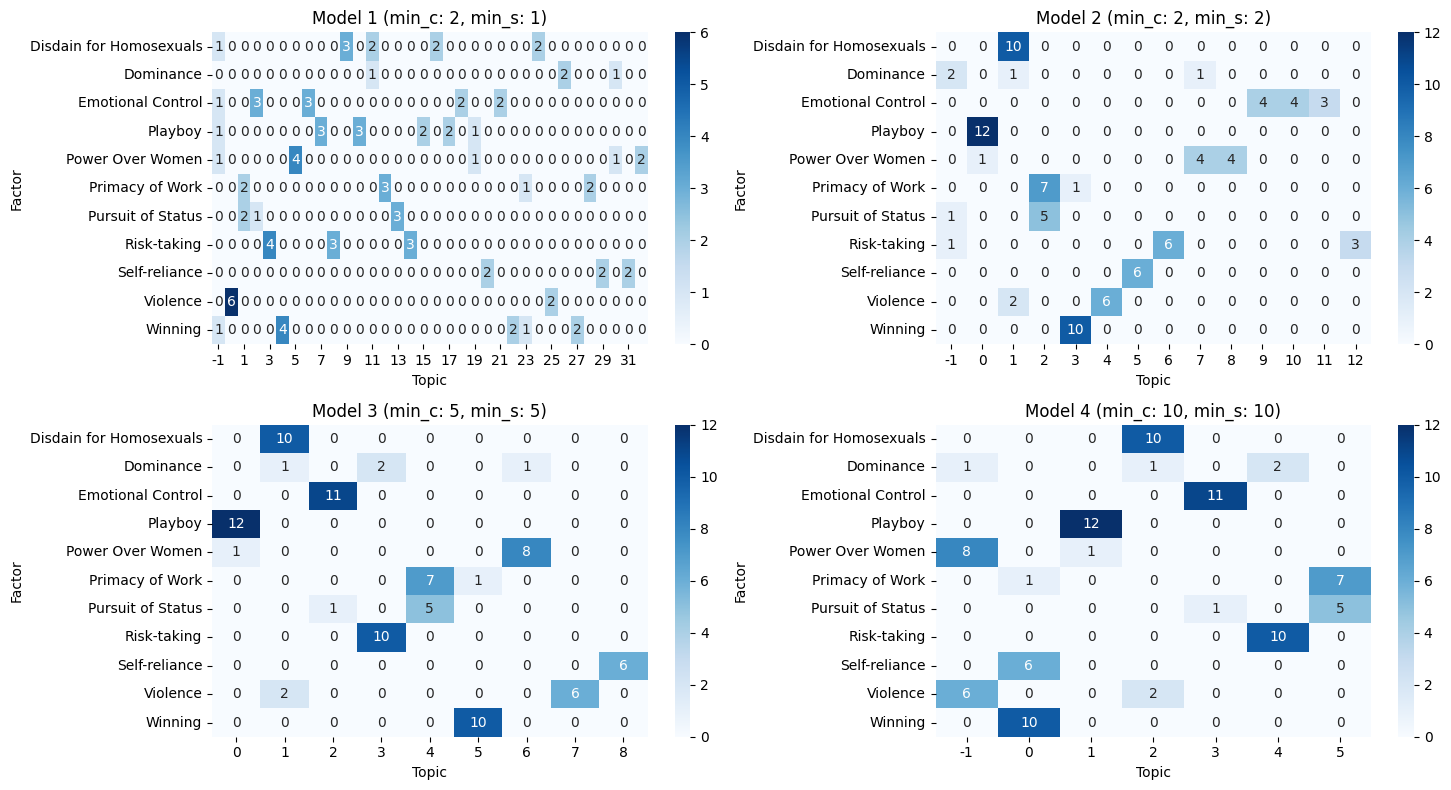

,Num Topics,Coherence (NPMI),Silhouette Score,ARI,Purity,NMI,Precision,Recall,F1
"(min cluster: 2, min sample: 1)",33.0,1.0,0.636757,0.296786,0.882979,0.739788,0.021277,0.010638,0.014184
"(min cluster: 2, min sample: 2)",13.0,1.0,0.791262,0.680537,0.861702,0.836588,0.106383,0.063830,0.079787
"(min cluster: 5, min sample: 5)",8.0,1.0,0.874702,0.787245,0.851064,0.874200,0.182110,0.202128,0.189728
"(min cluster: 10, min sample: 10)",6.0,1.0,0.783856,0.674083,0.723404,0.815289,0.026596,0.053191,0.035461


In [7]:
%run Functions/Functions.ipynb

def get_model_comparisons(models):
    # Create an empty DataFrame
    comparison_df = pd.DataFrame(columns=['Num Topics', 'Coherence (NPMI)', 'Silhouette Score', 'ARI', 'Purity', 'NMI', 'Precision', 'Recall', 'F1'])
        
    # Most popular model - Hugging Face: https://huggingface.co/sentence-transformers?sort_models=downloads#models
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    
    # remove stopwords/stop phrases containing 1 and 2 words
    # ngram_range is another potential parameter: ngram_range=(1, 2)
    vectorizer_model = CountVectorizer(stop_words="english")

    # Information for Cross-Tab Visualizations
    n_plots = len(models)
    n_rows = 2
    n_cols = n_plots // n_rows + (n_plots % n_rows > 0)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 8))
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]


    for index, mod in enumerate(models):
        ### Run custom model
        model = run_custom_BERTopic(docs, embedding_model, vectorizer_model, min_cluster_size=mod['min_cluster_size'], min_samples=mod['min_samples'])
        topics, probs = model.fit_transform(docs)
        
        topic_info_df = model.get_topic_info()
        
        num_topics = len(topic_info_df) - 1 # DOES NOT INCLUDE OUTLIERS TOPIC. ONLY COHERENT TOPICS

        ### Gather evaluation metrics
        coh = coherence_score(docs, model, vectorizer_model)
        
        # play with seeing if you actually need topics param here
        sil = silhouette_metric(docs, embedding_model, model, topics)
        
        true_values = df['Factor']
        predicted_values = model.get_document_info(docs)['Topic'] # NOTE THAT TOPIC -1 is included in the predicted_labels. Should we remove?!?!?!
  
        ari, purity, nmi = evaluation_metrics(true_values, predicted_values)
        
        precision, recall, f1 = f1score(true_values, predicted_values)
    
        comparison_df.loc[" (min cluster: " + str(mod['min_cluster_size']) + ", min sample: " + str(mod['min_samples']) + ")"] = [
            num_topics, coh, sil, ari, purity, nmi, precision, recall, f1]


        ### Generate visualizations
        cross_tab = pd.crosstab(true_values, predicted_values)

        # Heatmap
        sns.heatmap(cross_tab, cmap="Blues", annot=True, fmt="d", ax=axs[index])
        axs[index].set_title(f"Model {index+1} (min_c: {mod['min_cluster_size']}, min_s: {mod['min_samples']})")
    
    plt.tight_layout()
    plt.show()
    return comparison_df



# List of models as dictionaries
models = [
    {"min_cluster_size": 2, "min_samples": 1},
    {"min_cluster_size": 2, "min_samples": 2},
    {"min_cluster_size": 5, "min_samples": 5}, # I think this is default params for hdbscan, so other parameters are different
    {"min_cluster_size": 10, "min_samples": 10}
]

get_model_comparisons(models)